# Antibiotic resistance prediction

## Project Introduction
This project aims to predict antibiotic resistance using structured electronic health record (EHR) data from the Antibiotic Resistance Microbiology Dataset (ARMD). The goal is to classify whether a bacterial isolate is susceptible (S) or resistant (R) to a given antibiotic, based on clinical, demographic, microbiological, and treatment-related features. This binary classification model supports empirical antibiotic selection and contributes to combating antimicrobial resistance in clinical settings.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

final_armd_ds = 'ARMD_Dataset/selected_features_with_deltas.parquet'

df = pd.read_parquet(final_armd_ds)
print(df.shape)



(2184195, 38)


In [3]:
df.head()

,organism_x,antibiotic_x,resistant_time_to_culturetime,age,gender,adi_score,adi_state_rank,median_wbc,median_neutrophils,median_lymphocytes,...,last_cr,first_lactate,last_lactate,first_procalcitonin,last_procalcitonin,delta_wbc,delta_cr,delta_lactate,delta_procalcitonin,susceptibility_label
0,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S
1,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S
2,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S
3,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S
4,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,S


### Separate target + binary encoding

In [6]:
target_col = 'susceptibility_label'
df[target_col] = df[target_col].map({'S': 0, 'R': 1})  
y = df[target_col]
X = df.drop(columns=[target_col])
print('y: ',y.shape)
print('X: ',X.shape)

y:  (2184195,)
X:  (2184195, 37)


### Identify column types

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184195 entries, 0 to 2184194
Data columns (total 37 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   organism_x                      string 
 1   antibiotic_x                    string 
 2   resistant_time_to_culturetime   float64
 3   age                             string 
 4   gender                          string 
 5   adi_score                       string 
 6   adi_state_rank                  string 
 7   median_wbc                      string 
 8   median_neutrophils              string 
 9   median_lymphocytes              string 
 10  median_hgb                      string 
 11  median_plt                      string 
 12  median_na                       string 
 13  median_hco3                     string 
 14  median_bun                      string 
 15  median_cr                       string 
 16  median_lactate                  string 
 17  median_procalcitonin       

## Reduce memory usage by Downcast all float64 and Float64 columns to float32
- Check memory usage before and after

In [12]:
float_cols = ['first_wbc', 'last_wbc',
                'first_cr', 'last_cr', 'first_lactate', 'last_lactate',
                'first_procalcitonin', 'last_procalcitonin', 'delta_wbc',
                'delta_cr', 'delta_lactate', 'delta_procalcitonin']
print("Memory usage before:", df.memory_usage(deep=True).sum() / 1024**2, "MB")

# Downcast
df[float_cols] = df[float_cols].astype('float32')

print("Memory usage after:", df.memory_usage(deep=True).sum() / 1024**2, "MB")


Memory usage before: 2650.8075637817383 MB
Memory usage after: 2525.8269233703613 MB


## Column Categorization
- First, properly define all column categories
- Combine numerical features

In [14]:
true_categorical_cols = ['organism_x', 'antibiotic_x', 'gender', 'medication_category']
numeric_cols = ['resistant_time_to_culturetime', 'median_heartrate', 'median_resprate',
               'median_temp', 'median_sysbp', 'median_diasbp',
               'medication_time_to_culturetime','first_wbc', 'last_wbc',
                'first_cr', 'last_cr', 'first_lactate', 'last_lactate',
                'first_procalcitonin', 'last_procalcitonin', 'delta_wbc',
                'delta_cr', 'delta_lactate', 'delta_procalcitonin']
numerical_med_cols = ['median_wbc', 'median_neutrophils', 'median_lymphocytes',
                     'median_hgb', 'median_plt', 'median_na', 'median_hco3',
                     'median_bun', 'median_cr', 'median_lactate', 'median_procalcitonin']
ordinal_cols = ['age', 'adi_score', 'adi_state_rank']


all_numerical_cols = numeric_cols + numerical_med_cols


all_columns = true_categorical_cols + all_numerical_cols + ordinal_cols


## Apply CatBoost Encoding

#### Data Splitting

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nFinal Training Set Shape:", X_train.shape)
print("Final Test Set Shape:", X_test.shape)


Final Training Set Shape: (1747356, 37)
Final Test Set Shape: (436839, 37)


#### Ensure proper data types

In [22]:
X_train[true_categorical_cols] = X_train[true_categorical_cols].astype(str)
X_test[true_categorical_cols] = X_test[true_categorical_cols].astype(str)


#### Handle missing 
- Replace 'Null' with actual NaN values
- **For numerical columns**: Simple imputation (fill with mean/median/mode)
- **For categorical columns (if any)**: Fill with the most frequent.

In [25]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

def safe_impute(train_df, test_df, num_cols):
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Convert numeric columns to float, coercing errors
    for col in num_cols:
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

    # Replace all known NA-like strings with np.nan
    na_values = [pd.NA, pd.NaT, np.nan, None, 'NA', 'NaN', 'nan', 'null', 'Null']
    train_df[num_cols] = train_df[num_cols].replace(na_values, np.nan)
    test_df[num_cols] = test_df[num_cols].replace(na_values, np.nan)

    print("Missing values after conversion:")
    print(train_df[num_cols].isna().sum())

    # Filter out columns with all missing values in training set
    valid_cols = [col for col in num_cols if train_df[col].notna().sum() > 0]

    # Impute only valid columns
    num_imputer = SimpleImputer(strategy='median')
    train_imputed = num_imputer.fit_transform(train_df[valid_cols])
    test_imputed = num_imputer.transform(test_df[valid_cols])

    # Put imputed values back
    train_df[valid_cols] = pd.DataFrame(train_imputed, columns=valid_cols, index=train_df.index)
    test_df[valid_cols] = pd.DataFrame(test_imputed, columns=valid_cols, index=test_df.index)

    print("\nMissing values after imputation:")
    print(train_df[valid_cols].isna().sum())

    # Optional: Drop all-missing columns from both sets to keep shapes aligned
    dropped_cols = set(num_cols) - set(valid_cols)
    if dropped_cols:
        print(f"\nDropped columns with all missing values in training set: {dropped_cols}")
        train_df = train_df.drop(columns=dropped_cols)
        test_df = test_df.drop(columns=dropped_cols)

    return train_df, test_df


# Apply to your data
X_train, X_test = safe_impute(X_train, X_test, all_numerical_cols)

Missing values after conversion:
resistant_time_to_culturetime       23366
median_heartrate                    23822
median_resprate                     27518
median_temp                         24637
median_sysbp                        24087
median_diasbp                       24087
medication_time_to_culturetime      29372
first_wbc                         1744665
last_wbc                           195584
first_cr                           224904
last_cr                           1743396
first_lactate                     1747052
last_lactate                      1744932
first_procalcitonin               1747339
last_procalcitonin                1740602
delta_wbc                         1745028
delta_cr                          1747076
delta_lactate                     1747341
delta_procalcitonin               1747356
median_wbc                          14553
median_neutrophils                 149408
median_lymphocytes                 148739
median_hgb                          14553
m

In [26]:
print(X_train.shape)
print(X_test.shape)

(1747356, 36)
(436839, 36)


####  Ordinal Encoding

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# 1. First convert ALL ordinal columns to strings
ordinal_cols = ['age', 'adi_score', 'adi_state_rank']
X_train_ordinal = X_train[ordinal_cols].astype(str)
X_test_ordinal = X_test[ordinal_cols].astype(str)

# 2. Define proper ordering (after seeing your value counts)
age_order = [
    '18-24 years', 
    '25-34 years',
    '35-44 years',
    '45-54 years',
    '55-64 years',
    '65-74 years',
    '75-84 years',
    '85-89 years',
    'above 90'
]

# For numeric ordinals, convert to float first, then sort
adi_order = sorted([float(x) for x in X['adi_score'].unique() if x not in ['Null', 'missing']])
rank_order = sorted([float(x) for x in X['adi_state_rank'].unique() if x not in ['Null', 'missing']])

# 3. Create the pipeline with proper string handling
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder(
        categories=[age_order, adi_order, rank_order],
        handle_unknown='use_encoded_value',
        unknown_value=-1,
        dtype=np.int32
    ))
])

# 4. Fit and transform
ordinal_pipeline.fit(X_train_ordinal)
X_train[ordinal_cols] = ordinal_pipeline.transform(X_train_ordinal)
X_test[ordinal_cols] = ordinal_pipeline.transform(X_test_ordinal)

# 5. Verification
print("Encoded value counts:")
for col in ordinal_cols:
    print(f"\n{col}:")
    print(pd.Series(X_train[col]).value_counts().sort_index())

Encoded value counts:

age:
age
0      92143
1      10277
2       3094
3      69539
4    1551797
5       9668
6       7598
7       1524
8       1716
Name: count, dtype: int64

adi_score:
adi_score
-1    1747356
Name: count, dtype: int64

adi_state_rank:
adi_state_rank
-1    1747356
Name: count, dtype: int64


#### Apply CatBoost Encoding
Initialize CatBoost encoder with optimal settings
- Added noise to prevent overfitting
- Smoothing parameter

Fit and transform - ensuring no data leakage

In [32]:
from category_encoders import CatBoostEncoder
cbe = CatBoostEncoder(
    cols=true_categorical_cols,
    random_state=42,
    sigma=0.1,  # noise
    a=1.0       # Smoothing
)

X_train_encoded = cbe.fit_transform(X_train[true_categorical_cols], y_train)
X_test_encoded = cbe.transform(X_test[true_categorical_cols])

#### Create final feature sets

In [35]:
# Recalculate valid numerical columns post-imputation
available_numerical_cols = [col for col in all_numerical_cols if col in X_train.columns]

# Now safely build final_features
final_features = true_categorical_cols + available_numerical_cols + ordinal_cols

# Then build X_train_final and X_test_final
X_train_final = pd.concat([
    X_train_encoded,
    X_train[available_numerical_cols + ordinal_cols]
], axis=1)[final_features]

X_test_final = pd.concat([
    X_test_encoded,
    X_test[available_numerical_cols + ordinal_cols]
], axis=1)[final_features]


### Save as Parquet

In [37]:
import pandas as pd

# Combine train and test features
X_full = pd.concat([X_train_final, X_test_final], axis=0)

# Combine corresponding target labels
y_full = pd.concat([y_train, y_test], axis=0)

# Add the target as a column
full_dataset = X_full.copy()
full_dataset['susceptibility_label'] = y_full

# Save to Parquet
full_dataset.to_parquet("numeric_dataset_CatBoostEncoder.parquet", index=False)

print("✅ All features numeric and saved to 'numeric_dataset_CatBoostEncoder.parquet'")

✅ All features numeric and saved to 'numeric_dataset_CatBoostEncoder.parquet'


### Load the Data

In [1]:
import pandas as pd

df = pd.read_parquet("numeric_dataset_CatBoostEncoder.parquet")
X = df.drop(columns=["susceptibility_label"])
y = df["susceptibility_label"]
print('y: ',y.shape)
print('X: ',X.shape)

y:  (2184195,)
X:  (2184195, 36)


### Correlation Features

In [4]:
correlation = df.corr()['susceptibility_label'].sort_values(ascending=False)
print(correlation)

susceptibility_label              1.000000
antibiotic_x                      0.203597
median_heartrate                  0.162111
median_hco3                       0.157591
median_plt                        0.142677
median_lactate                    0.127707
median_diasbp                     0.106129
organism_x                        0.095640
medication_category               0.092608
median_lymphocytes                0.066840
median_sysbp                      0.066204
gender                            0.019132
median_wbc                        0.007792
delta_wbc                         0.007449
last_wbc                          0.006466
delta_lactate                     0.001549
last_lactate                      0.000324
last_procalcitonin                0.000243
delta_cr                         -0.000105
first_lactate                    -0.001241
last_cr                          -0.006196
first_wbc                        -0.013252
resistant_time_to_culturetime    -0.016621
median_na  

## Train/Test Split + Scale

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Models implementation 

## Random Forest

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.62      0.33      0.43    249846
           1       0.45      0.72      0.55    186993

    accuracy                           0.50    436839
   macro avg       0.53      0.53      0.49    436839
weighted avg       0.54      0.50      0.48    436839


ROC AUC Score: 0.557

Confusion Matrix:
[[ 83041 166805]
 [ 51869 135124]]


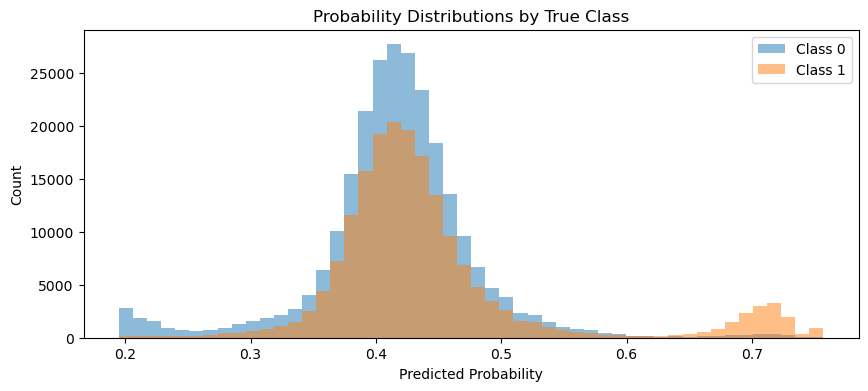

In [9]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create the modeling pipeline
model = make_pipeline(
    RobustScaler(),  # Still useful for scaling, though Random Forests are less sensitive
    RandomForestClassifier(
        n_estimators=200,  # Number of trees in the forest
        max_depth=None,    # Let trees grow fully (can tune this)
        min_samples_split=2, 
        min_samples_leaf=1,
        class_weight='balanced',  # Automatic class balancing
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
)

# 2. Train with probability calibration (Random Forests sometimes benefit from calibration)
calibrated_model = CalibratedClassifierCV(model, cv=3)
calibrated_model.fit(X_train, y_train)

# 3. Make predictions (with adjusted threshold)
y_prob = calibrated_model.predict_proba(X_test)[:,1]
y_pred_adj = (y_prob > 0.4).astype(int)  # Using 0.4 threshold instead of default 0.5

# 4. Evaluate performance
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_adj))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adj))

# 5. Visual inspection of probabilities
plt.figure(figsize=(10, 4))
plt.hist(y_prob[y_test==0], bins=50, alpha=0.5, label='Class 0')
plt.hist(y_prob[y_test==1], bins=50, alpha=0.5, label='Class 1')
plt.legend()
plt.title("Probability Distributions by True Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()

## Best Models and Techniques for Overlapping Classes

**Gradient Boosting Trees (e.g., XGBoost, LightGBM, CatBoost)**
- They handle non-linear boundaries well and are more robust to overlapping regions than Random Forests.
- LightGBM is very fast on large datasets.
- Use `scale_pos_weight` to handle class imbalance, and tune `max_depth`, `min_child_weight`, and `learning_rate`.

## LightGBM Modeling Pipeline

LightGBM Performance:
              precision    recall  f1-score   support

           0       0.80      0.09      0.17    249846
           1       0.44      0.97      0.61    186993

    accuracy                           0.47    436839
   macro avg       0.62      0.53      0.39    436839
weighted avg       0.65      0.47      0.36    436839


ROC AUC Score: 0.566

Confusion Matrix:
[[ 23256 226590]
 [  5856 181137]]


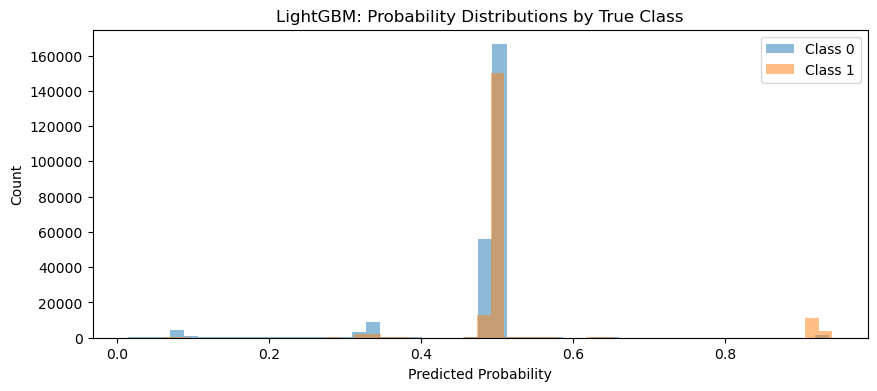

In [7]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. Estimate imbalance ratio for scale_pos_weight
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
imbalance_ratio = neg / pos

# 2. Define the LightGBM model
lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=30,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    n_jobs=-1
)

# 3. Train the model
lgbm.fit(X_train, y_train)

# 4. Predict probabilities and adjust threshold
y_prob = lgbm.predict_proba(X_test)[:, 1]
y_pred_adj = (y_prob > 0.4).astype(int)

# 5. Evaluate performance
print("LightGBM Performance:")
print(classification_report(y_test, y_pred_adj))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adj))

# 6. Plot histogram of predicted probabilities
plt.figure(figsize=(10, 4))
plt.hist(y_prob[y_test==0], bins=50, alpha=0.5, label='Class 0')
plt.hist(y_prob[y_test==1], bins=50, alpha=0.5, label='Class 1')
plt.legend()
plt.title("LightGBM: Probability Distributions by True Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()


In [5]:
import lightgbm as lgb
from sklearn.metrics import (classification_report, roc_auc_score, 
                           confusion_matrix, precision_recall_curve, 
                           average_precision_score, balanced_accuracy_score)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Calculate class weights
neg, pos = np.bincount(y_train)
imbalance_ratio = neg / pos
print(f"Class distribution - Negative: {neg}, Positive: {pos}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

# 2. Define LightGBM model with balanced parameters
lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=imbalance_ratio,
    objective='binary',
    metric='auc',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 3. Train with early stopping using callbacks
early_stopping = lgb.early_stopping(stopping_rounds=50, verbose=True)
eval_metric = lgb.log_evaluation(period=10)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric=['auc', 'binary_logloss'],
    callbacks=[early_stopping, eval_metric]
)

# 4. Predict probabilities
y_prob = lgbm.predict_proba(X_test)[:, 1]

# 5. Find optimal threshold using precision-recall tradeoff
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# 6. Evaluate with optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

print("\nLightGBM Performance with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_optimal):.3f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.3f}")
print(f"Average Precision: {average_precision_score(y_test, y_prob):.3f}")

# 7. Confusion

Class distribution - Negative: 999382, Positive: 747974
Imbalance ratio: 1.34
Training until validation scores don't improve for 50 rounds
[10]	training's binary_logloss: 0.678465	training's auc: 0.56571	valid_1's binary_logloss: 0.678431	valid_1's auc: 0.566491
[20]	training's binary_logloss: 0.675113	training's auc: 0.56564	valid_1's binary_logloss: 0.675053	valid_1's auc: 0.566359
[30]	training's binary_logloss: 0.672436	training's auc: 0.565596	valid_1's binary_logloss: 0.672357	valid_1's auc: 0.56633
[40]	training's binary_logloss: 0.670312	training's auc: 0.565588	valid_1's binary_logloss: 0.670218	valid_1's auc: 0.566324
[50]	training's binary_logloss: 0.668625	training's auc: 0.565581	valid_1's binary_logloss: 0.668519	valid_1's auc: 0.566307
[60]	training's binary_logloss: 0.667287	training's auc: 0.565565	valid_1's binary_logloss: 0.667172	valid_1's auc: 0.56628
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.678096	training's auc: 0.565691	valid_1's bina

## SVM + Kernels

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (classification_report, roc_auc_score,
                             confusion_matrix, precision_recall_curve,
                             average_precision_score, balanced_accuracy_score)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
import time

# === Preprocessing ===
# Scale the data (if not already done)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Define kernels and results container ===
kernels = ['linear', 'poly', 'rbf']
results = {}

# === Subsample data for faster tuning ===
X_sample, y_sample = resample(X_train_scaled, y_train, n_samples=10000, stratify=y_train, random_state=42)

# === Loop over kernels ===
for kernel in kernels:
    print(f"\n=== Training SVM with {kernel} kernel ===")
    start_time = time.time()

    if kernel == 'linear':
        base_model = LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)
        model = CalibratedClassifierCV(base_model, cv=3)
        param_grid = {
            'estimator__C': [0.1, 1, 10]  # <- FIXED
        }



    else:
        base_model = SVC(kernel=kernel, probability=True, class_weight='balanced', random_state=42)
        param_grid = {'C': [0.1, 1, 10]}
        if kernel == 'poly':
            param_grid.update({'degree': [2, 3], 'coef0': [0.0, 1.0]})
        if kernel == 'rbf':
            param_grid.update({'gamma': ['scale', 'auto']})
        model = base_model  # SVC directly

    # Randomized search (faster than grid)
    search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5,
                                scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)

    search.fit(X_sample, y_sample)
    best_model = search.best_estimator_
    print(f"Best parameters: {search.best_params_}")

    # Retrain best model on full training set
    best_model.fit(X_train_scaled, y_train)

    # Predict probabilities and evaluate
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    # Find optimal threshold using F1 score
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_prob >= optimal_threshold).astype(int)

    # Store results
    results[kernel] = {
        'model': best_model,
        'threshold': optimal_threshold,
        'report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'avg_precision': average_precision_score(y_test, y_prob),
        'bal_accuracy': balanced_accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'time': time.time() - start_time
    }

    # Print results
    print(f"\nSVM with {kernel} kernel performance:")
    print(results[kernel]['report'])
    print(f"ROC AUC: {results[kernel]['roc_auc']:.3f}")
    print(f"Average Precision: {results[kernel]['avg_precision']:.3f}")
    print(f"Balanced Accuracy: {results[kernel]['bal_accuracy']:.3f}")
    print(f"Training time: {results[kernel]['time']:.2f} seconds")

# === Compare all kernels ===
print("\n=== Kernel Comparison ===")
for kernel in kernels:
    print(f"\n{kernel.upper()} Kernel:")
    print(f"ROC AUC: {results[kernel]['roc_auc']:.3f}")
    print(f"Avg Precision: {results[kernel]['avg_precision']:.3f}")
    print(f"Balanced Accuracy: {results[kernel]['bal_accuracy']:.3f}")
    print(f"Training Time: {results[kernel]['time']:.2f}s")

# === Plot probability distributions and PR curve for best model ===
best_kernel = max(results.keys(), key=lambda k: results[k]['roc_auc'])
best_model = results[best_kernel]['model']
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_prob[y_test == 0], bins=50, alpha=0.5, label='Class 0', density=True)
plt.hist(y_prob[y_test == 1], bins=50, alpha=0.5, label='Class 1', density=True)
plt.legend()
plt.title(f"SVM ({best_kernel} kernel) - Probability Distributions")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")

plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, label=f'SVM ({best_kernel})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

# === Confusion Matrix for Best Model ===
print(f"\nConfusion Matrix for best kernel ({best_kernel}):")
print(results[best_kernel]['confusion_matrix'])



=== Training SVM with linear kernel ===


D:\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'estimator__C': 0.1}

SVM with linear kernel performance:
              precision    recall  f1-score   support

           0       0.79      0.09      0.16    249846
           1       0.44      0.97      0.61    186993

    accuracy                           0.47    436839
   macro avg       0.62      0.53      0.39    436839
weighted avg       0.64      0.47      0.35    436839

ROC AUC: 0.565
Average Precision: 0.522
Balanced Accuracy: 0.529
Training time: 37.58 seconds

=== Training SVM with poly kernel ===
Best parameters: {'degree': 2, 'coef0': 0.0, 'C': 0.1}


## Complete and optimized XGBoost training + evaluation pipeline:
- Class weighting
- Early stopping
- Precision-recall tuning
- ROC AUC & PR evaluation
- Balanced accuracy and confusion matrix

In [ ]:
import xgboost as xgb
from sklearn.metrics import (classification_report, roc_auc_score, 
                             confusion_matrix, precision_recall_curve,
                             average_precision_score, balanced_accuracy_score)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time

# 1. Convert to DMatrix (XGBoost's internal data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 2. Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # handle imbalance
    'learning_rate': 0.1,
    'max_depth': 6,
    'random_state': 42,
    'nthread': -1,
    'tree_method': 'hist'  # Faster for large datasets
}

# 3. Train model with early stopping
start_time = time.time()
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"\nTraining completed in {time.time() - start_time:.2f} seconds")

# 4. Predict probabilities and find optimal threshold
y_prob = xgb_model.predict(dtest)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_prob >= optimal_threshold).astype(int)

# 5. Evaluation
print("\n=== XGBoost Performance ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")
print(f"Average Precision: {average_precision_score(y_test, y_prob):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 6. Plot probability distributions and PR curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_prob[y_test==0], bins=50, alpha=0.5, label='Class 0', density=True)
plt.hist(y_prob[y_test==1], bins=50, alpha=0.5, label='Class 1', density=True)
plt.title("XGBoost: Probability Distributions")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title("XGBoost: Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()
